# WSiLU — Mapeamento `x` (0..2**N−1) ➜ `y` em decimal e hexadecimal

Notebook baseado no seu código. Ele:
1. Mantém a mesma lógica de quantização:
   - `SCALE = 5 / (2**N_bits)`
   - limites em `[-2.5, 2.5)` para conversão `fp2intrep`
   - `y = x * sigmoid(4*x)`
   - quantização por **trunc**
2. Gera a **LUT** (índice assinado) e, em seguida, constrói um **mapeamento** por **índice não assinado** `x_u ∈ [0, 2**N_bits-1]`:
   - `x_u (decimal)` e `x_hex` (hex de `x_u`, zero-padded)
   - `x_int_signed` correspondente (`x_u + MIN_INT`)
   - `x_fp`
   - `y_int` (decimal, assinado) e `y_hex` (hex em **complemento de dois** com largura `N_bits`)
   - `y_fp` reconstruído
3. Mostra **head/tail** da tabela, **gráfico** de `y_fp` vs `x_fp` e calcula **MSE**.
4. Permite **exportar CSV**.

> Observação: muitos `0xFFFF` no início (para 16 bits) são esperados, pois correspondem a `-1` após `trunc` perto de `x = -2.5`.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Parâmetros
# =====================
N_bits = 8  # altere aqui

N = 2 ** N_bits
SCALE = 5.0 / N
MAX_INT = int(N//2 - 1)
MIN_INT = int(-N//2)

print(f"SCALE={SCALE}")

SCALE=0.01953125


In [8]:
# =====================
# Funções (do seu código, levemente organizadas)
# =====================
def fp2intrep(x: float) -> int:
    if x < -2.5:
        x_int = MIN_INT
    elif x >= 2.5:
        x_int = MAX_INT
    else:
        # trunc conforme seu código
        x_int = int(x / SCALE)
    return x_int

def int2fprep(x_int: int) -> float:
    return float(x_int * SCALE)

def sigmoid(x):
    # mesma forma: sigmoid(4*x)
    return 1.0 / (1.0 + np.exp(-x * 4.0))

def to_hex_unsigned(val: int, n_bits: int) -> str:
    width = (n_bits + 3) // 4
    return f"0x{val:0{width}X}"

def to_hex_twos_complement_signed(val: int, n_bits: int) -> str:
    mask = (1 << n_bits) - 1
    width = (n_bits + 3) // 4
    u = (val & mask)
    return f"0x{u:0{width}X}"

In [9]:
# =====================
# Construção da LUT (índice assinado)
# =====================
LUT = []  # y_int por x_int (assinado) de MIN_INT..MAX_INT
for x_int in range(MIN_INT, MAX_INT + 1):
    x_fp = x_int * SCALE
    y_fp = sigmoid(x_fp) * x_fp
    y_int = fp2intrep(y_fp)
    LUT.append(y_int)

LUT = np.array(LUT, dtype=np.int64)
print("LUT gerada:", LUT.shape)

# Função forward (vetorizada) usando LUT
def forward(x):
    if np.isscalar(x):
        if x >= 2.5:
            return x
        x_int = fp2intrep(x)
        wsilu = LUT[int(x_int - MIN_INT)]  # desloca por MIN_INT
        return int2fprep(wsilu)
    elif isinstance(x, np.ndarray):
        f = np.vectorize(forward)
        return f(x)
    else:
        raise TypeError("Entrada deve ser número escalar ou numpy.ndarray")

LUT gerada: (256,)


In [10]:
# =====================
# Mapeamento pedido: x (0..2**N_bits-1) -> y (decimal e hex)
# =====================
x_unsigned = np.arange(0, N, dtype=np.uint64)
x_hex = np.array([to_hex_unsigned(int(xu), N_bits) for xu in x_unsigned])

# Relaciona para o índice assinado (MIN_INT..MAX_INT)
x_int_signed = (x_unsigned.astype(np.int64) + MIN_INT)
x_fp = x_int_signed * SCALE

# y_int vem da LUT pelo índice assinado
y_int = LUT[(x_int_signed - MIN_INT).astype(np.int64)]
y_hex = np.array([to_hex_twos_complement_signed(int(v), N_bits) for v in y_int])
y_fp = y_int * SCALE

df = pd.DataFrame({
    "x_unsigned": x_unsigned.astype(object),
    "x_hex": x_hex,
    "x_int_signed": x_int_signed.astype(object),
    "x_fp": x_fp.astype(np.float64),
    "y_int": y_int.astype(object),
    "y_hex": y_hex,
    "y_fp": y_fp.astype(np.float64),
})

print("Amostra (head):")
display(df.head(10))
print("Amostra (tail):")
display(df.tail(10))
print(f"Total de linhas: {len(df):,}")

Amostra (head):


,x_unsigned,x_hex,x_int_signed,x_fp,y_int,y_hex,y_fp
0,0,0x00,-128,-2.500000,0,0x00,0.0
1,1,0x01,-127,-2.480469,0,0x00,0.0
2,2,0x02,-126,-2.460938,0,0x00,0.0
3,3,0x03,-125,-2.441406,0,0x00,0.0
4,4,0x04,-124,-2.421875,0,0x00,0.0
5,5,0x05,-123,-2.402344,0,0x00,0.0
6,6,0x06,-122,-2.382812,0,0x00,0.0
7,7,0x07,-121,-2.363281,0,0x00,0.0
8,8,0x08,-120,-2.343750,0,0x00,0.0
9,9,0x09,-119,-2.324219,0,0x00,0.0


Amostra (tail):


,x_unsigned,x_hex,x_int_signed,x_fp,y_int,y_hex,y_fp
246,246,0xF6,118,2.304688,117,0x75,2.285156
247,247,0xF7,119,2.324219,118,0x76,2.304688
248,248,0xF8,120,2.343750,119,0x77,2.324219
249,249,0xF9,121,2.363281,120,0x78,2.343750
250,250,0xFA,122,2.382812,121,0x79,2.363281
251,251,0xFB,123,2.402344,122,0x7A,2.382812
252,252,0xFC,124,2.421875,123,0x7B,2.402344
253,253,0xFD,125,2.441406,124,0x7C,2.421875
254,254,0xFE,126,2.460938,125,0x7D,2.441406
255,255,0xFF,127,2.480469,126,0x7E,2.460938


Total de linhas: 256


mse=0.000348159717895726


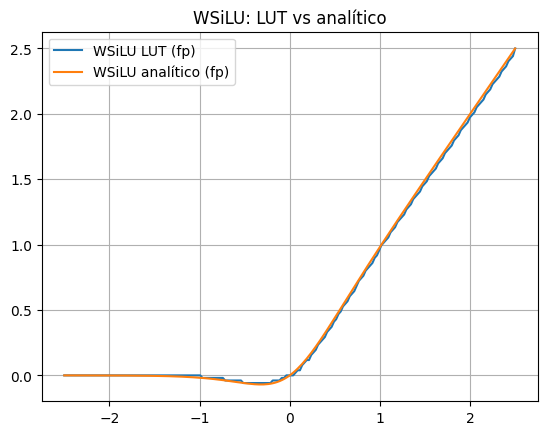

In [11]:
# =====================
# Gráfico e MSE (comparando LUT vs função float)
# =====================
x_plot = np.linspace(-2.5, 2.5, 200)
y_int_plot = forward(x_plot)
y_fp_plot = x_plot * sigmoid(x_plot)

mse = np.mean((y_int_plot - y_fp_plot) ** 2)
print(f"mse={mse}")

plt.figure()
plt.plot(x_plot, y_int_plot, label="WSiLU LUT (fp)")
plt.plot(x_plot, y_fp_plot, label="WSiLU analítico (fp)")
plt.title("WSiLU: LUT vs analítico")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# =====================
# Exportar CSV (opcional)
# =====================
save_csv = False  # mude para True para salvar
csv_path = f"wsilu_mapping_{N_bits}b.csv"
if save_csv:
    df.to_csv(csv_path, index=False)
    print(f"CSV salvo em: {csv_path}")
else:
    print("Exportação desativada (save_csv=False)")

Exportação desativada (save_csv=False)
